# <center> Mortality Risk Prediction: Machine Learning Model Development </center>

This notebook outlines the machine learning pipeline for predicting three critical child mortality outcomes: **Under-5 Mortality**, **Infant Mortality**, and **Neonatal Mortality**.

We will cover:
1.  Setup and Definition of Evaluation Metrics.
2.  Advanced Data Preparation and Feature Engineering.
3.  Training of Multiple Classifiers (Logistic Regression, Gradient Boosting, XGBoost, DNN, and Random Forest).
4.  Final Model Comparison and Selection.

---

## 1. Setup and Evaluation Metrics

### 1.1 Library Imports and Configuration

We import all necessary libraries for data processing (`pandas`, `numpy`), visualization, standard machine learning (`sklearn`), ensemble methods (`XGBoost`, `RandomForest`), deep learning (`TensorFlow`, `KerasClassifier`), and techniques for handling class imbalance (`imblearn`).

### 1.2 Build a Baseline Model

In [2]:
# Install any required packages 
# !pip install tensorflow scikeras xgboost imbalanced-learn

# Standard Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, precision_recall_curve, auc, fbeta_score,
    average_precision_score, make_scorer, roc_curve, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, RandomForestClassifier

# Imbalanced-learn 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# SciKeras 
from scikeras.wrappers import KerasClassifier

# XGBoost 
from xgboost import XGBClassifier

# Settings 
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")



This section summarises the performance of all models evaluated on the Under-5 Mortality, Infant Mortality, and Neonatal Mortality classification tasks.

Each model is evaluated using the following metrics:

- Accuracy: Proportion of correct predictions

- F2 Score: Prioritizes recall over precision (important in mortality predictions)

- ROC-AUC: Area under the Receiver Operating Characteristic curve

- PR-AUC: Area under the Precision-Recall curve

In [3]:
# Model Comparison Storage
results = []

def log_results(model_name, target_name, y_true, y_pred, y_prob):
    """Append evaluation metrics to global results list."""
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)

    results.append({
        "Model": model_name,
        "Target": target_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F2 Score": fbeta_score(y_true, y_pred, beta=2),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "PR-AUC": pr_auc
    })



### 2.1 Data Loading and Initial Type Assignment

The cleaned dataset (`u5mr_clean.csv`) is loaded. We explicitly set data types for continuous, discrete, and categorical features to ensure the preprocessing pipeline handles them correctly.

### 2.2 Feature Engineering for Model Robustness

To create a more powerful and generalized model, we perform several advanced feature engineering steps:

#### A. Multicollinearity and Leakage Mitigation
Features highly correlated with the target or with each other are transformed or removed. For instance, we drop columns that could potentially cause data leakage and address multicollinearity by calculating **Child BMI** from height and weight.

#### B. Creation of Risk Factors
We create new features based on known epidemiological risk factors:
* **Log Household Size:** Log-transformed to normalize distribution.
* **Socioeconomic Score:** A combined measure of wealth and education.
* **Short Birth Interval:** A binary flag for high-risk, closely-spaced births.

#### C. Handling Sparse Categorical Data
Rare categories within variables like `Ethnicity` and `Religion` are grouped into an 'Other' category to reduce dimensionality and improve the stability of the One-Hot Encoder.

In [4]:
df=pd.read_csv('u5mr_clean.csv')

In [5]:
# Make a safe working copy
df = df.copy()

# Object ID
df['CASEID'] = df['CASEID'].astype('object')

# Continuous floats
float_vars = [
    'Age in 5-year groups',
    'Birth weight in kilograms (3 decimals)',
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Months of breastfeeding',
    'When child put to breast',
    'Height/Age standard deviation (new WHO)',
    'Weight/Age standard deviation (new WHO)',
    'Weight/Height standard deviation (new WHO)'
]
df[float_vars] = df[float_vars].apply(pd.to_numeric, errors="coerce").astype('float64')

# Discrete ints (nullable safe type)
int_vars = [
    'Number of household members (listed)',
    'Birth order number',
    'Preceding birth interval (months)',
    'Succeeding birth interval (months)',
    'Duration of pregnancy in months',
    'Timing of 1st antenatal check (months)',
    'Number of antenatal visits during pregnancy',
    'Entries in pregnancy and postnatal care roster',
    'Minutes to nearest healthcare facility',
    'Number of tetanus injections before birth',
    'Number of tetanus injections before pregnancy'
]
df[int_vars] = df[int_vars].apply(pd.to_numeric, errors="coerce").astype('Int64')

# Categorical (nominal/ordinal)
cat_vars = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Wealth index combined',
    'Type of cooking fuel (smoke exposure, indoor air pollution)',
    'Sex of child',
    'Place of delivery',
    'Size of child at birth',
    'Has health card and or other vaccination document',
    'Ever had vaccination',
    'Place where most vaccinations were received',
    'Yellow fever vaccine',
    'Currently breastfeeding',
    'Given child anything other than breast milk',
    'In contact with someone with cough or TB',
    'Source of drinking water',
    'Main floor material',
    'Visited health facility last 12 months',
    'Getting medical help for self: distance to health facility',
    'Mode of transportation to nearest healthcare facility',
]
df[cat_vars] = df[cat_vars].astype('category')

In [6]:
df.columns

Index(['CASEID', 'Age in 5-year groups', 'Region',
       'Type of place of residence', 'Highest educational level', 'Religion',
       'Ethnicity', 'Number of household members (listed)',
       'Wealth index combined',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       ...
       'Received inactivated polio (IPV)_missing',
       'Received Rotavirus 2_missing',
       'Place where most vaccinations were received_missing',
       'Yellow fever vaccine_missing',
       'Given child anything other than breast milk_missing',
       'Visited health facility last 12 months_missing',
       'Getting medical help for self: distance to health facility_missing',
       'Mode of transportation to nearest healthcare facility_missing',
       'prenatal_help_missing', 'delivery_help_missing'],
      dtype='object', length=104)

In [7]:
# pattern to drop all columns that end with '_missing' or contain 'vaccine'
leakage_cols = [col for col in df.columns
                if col.endswith('_missing')
                or 'vaccine' in col.lower()
                or 'Received' in col]

# explicitly drop known outcome columns
outcome_cols = [
    'under5_mortality','infant_mortality','neonatal_mortality',
    'mortality_category'
]

In [8]:
leakage_cols

['Received BCG',
 'Received POLIO 1',
 'Received POLIO 2',
 'Received POLIO 3',
 'Received POLIO 0',
 'Received MEASLES 1',
 'Received MEASLES 2',
 'Received Pentavalent 1',
 'Received Pentavalent 2',
 'Received Pentavalent 3',
 'Received Pneumococcal 1',
 'Received Pneumococcal 2',
 'Received Pneumococcal 3',
 'Received Rotavirus 1',
 'Received inactivated polio (IPV)',
 'Received Rotavirus 2',
 'Yellow fever vaccine',
 'Preceding birth interval (months)_missing',
 'Succeeding birth interval (months)_missing',
 'Timing of 1st antenatal check (months)_missing',
 'Number of antenatal visits during pregnancy_missing',
 'Birth weight in kilograms (3 decimals)_missing',
 'Ever had vaccination_missing',
 'Months of breastfeeding_missing',
 'When child put to breast_missing',
 'Minutes to nearest healthcare facility_missing',
 'Number of tetanus injections before birth_missing',
 'Number of tetanus injections before pregnancy_missing',
 'Place of delivery_missing',
 'Size of child at birth_m

In [9]:
## Handle skewed numeric features
# Log transform household size to reduce right skew
if 'Number of household members (listed)' in df.columns:
    df['log_household_size'] = np.log1p(df['Number of household members (listed)'])

In [10]:
# Socioeconomic score: combine wealth + education (if both exist and numeric/categorical)
if {'Wealth index combined','Highest educational level'}.issubset(df.columns):
    # Ensure we have numeric codes for both
    df['Wealth index combined'] = df['Wealth index combined'].astype('category').cat.codes
    df['Highest educational level'] = df['Highest educational level'].astype('category').cat.codes
    df['socioeconomic'] = (df['Wealth index combined']
                           + df['Highest educational level'])

In [11]:
# Interval features
if 'Preceding birth interval (months)' in df.columns:
    df['short_birth_interval'] = (
        df['Preceding birth interval (months)'] < 24
    ).astype(int)

In [12]:
for col in ['Ethnicity', 'Religion']:
    if col in df.columns:
        # ensure it's plain string, not Categorical
        df[col] = df[col].astype(str)

        counts = df[col].value_counts()
        rare = counts[counts < 50].index

        # replace all rare categories with "Other"
        df[col] = df[col].replace(list(rare), 'Other')


In [13]:
X = df.drop(columns=leakage_cols + outcome_cols + ['CASEID'])

In [14]:
corr = X.corr(numeric_only=True).abs()
high_corr = np.where(corr > 0.9)
pairs = [(corr.index[i], corr.columns[j])
         for i,j in zip(*high_corr)
         if i < j]
print(pairs)

[('Number of household members (listed)', 'log_household_size'), ('Wealth index combined', 'socioeconomic'), ('Childs weight in kilograms (1 decimal)', 'Childs height in centimeters (1 decimal)')]


In [15]:
# create BMI column
df['child_BMI'] = df['Childs weight in kilograms (1 decimal)'] / (
    (df['Childs height in centimeters (1 decimal)'] / 100) ** 2
)

# drop originals to avoid multicollinearity
df = df.drop(columns=[
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Number of household members (listed)',
    'Wealth index combined'
])
df['child_BMI'] = df['child_BMI'].round(2)

In [16]:
print("Feature engineering complete. New shape:", df.shape)

Feature engineering complete. New shape: (19530, 104)


In [17]:
df.head()

,CASEID,Age in 5-year groups,Region,Type of place of residence,Highest educational level,Religion,Ethnicity,"Type of cooking fuel (smoke exposure, indoor air pollution)",Birth order number,Sex of child,Preceding birth interval (months),Succeeding birth interval (months),Duration of pregnancy in months,Timing of 1st antenatal check (months),Number of antenatal visits during pregnancy,Place of delivery,Size of child at birth,Birth weight in kilograms (3 decimals),Has health card and or other vaccination document,Received BCG,Received POLIO 1,Received POLIO 2,Received POLIO 3,Received POLIO 0,Received MEASLES 1,Received MEASLES 2,Received Pentavalent 1,Received Pentavalent 2,Received Pentavalent 3,Received Pneumococcal 1,Received Pneumococcal 2,Received Pneumococcal 3,Received Rotavirus 1,Received inactivated polio (IPV),Received Rotavirus 2,Ever had vaccination,Place where most vaccinations were received,Yellow fever vaccine,Currently breastfeeding,Months of breastfeeding,...,Timing of 1st antenatal check (months)_missing,Number of antenatal visits during pregnancy_missing,Birth weight in kilograms (3 decimals)_missing,Ever had vaccination_missing,Months of breastfeeding_missing,When child put to breast_missing,Minutes to nearest healthcare facility_missing,Number of tetanus injections before birth_missing,Number of tetanus injections before pregnancy_missing,Place of delivery_missing,Size of child at birth_missing,Has health card and or other vaccination document_missing,Received BCG_missing,Received POLIO 1_missing,Received POLIO 2_missing,Received POLIO 3_missing,Received POLIO 0_missing,Received MEASLES 1_missing,Received MEASLES 2_missing,Received Pentavalent 1_missing,Received Pentavalent 2_missing,Received Pentavalent 3_missing,Received Pneumococcal 1_missing,Received Pneumococcal 2_missing,Received Pneumococcal 3_missing,Received Rotavirus 1_missing,Received inactivated polio (IPV)_missing,Received Rotavirus 2_missing,Place where most vaccinations were received_missing,Yellow fever vaccine_missing,Given child anything other than breast milk_missing,Visited health facility last 12 months_missing,Getting medical help for self: distance to health facility_missing,Mode of transportation to nearest healthcare facility_missing,prenatal_help_missing,delivery_help_missing,log_household_size,socioeconomic,short_birth_interval,child_BMI
0,1 4 2,4.0,1.0,1.0,0,7.0,11.0,2.0,4,1.0,92,25,9,5,5,21.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,22.0,0.0,1.0,7.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.94591,3,0,1.92
1,1 13 2,5.0,1.0,1.0,2,1.0,3.0,2.0,5,2.0,30,25,9,4,4,21.0,3.0,3.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,0.0,0.0,9.0,...,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,2.197225,6,0,1.79
2,1 26 2,3.0,1.0,1.0,2,3.0,3.0,2.0,3,1.0,23,25,9,4,4,21.0,3.0,3.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,0.0,0.0,9.0,...,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1.791759,5,1,1.45
3,1 42 1,4.0,1.0,1.0,2,4.0,3.0,2.0,1,2.0,37,25,9,4,4,21.0,3.0,3.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,0.0,0.0,9.0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.386294,6,0,1.40
4,1 55 2,4.0,1.0,1.0,2,2.0,3.0,2.0,2,1.0,23,25,9,6,3,21.0,3.0,3.4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,0.0,1.0,4.0,...,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1.609438,6,1,1.69


## 3. Model Development Pipeline

### 3.1 Preprocessing Pipeline Definition

A robust `ColumnTransformer` is defined to automate preprocessing across all models:
* **Numerical Features:** Scaled using `StandardScaler`.
* **Categorical Features:** One-Hot Encoded using `OneHotEncoder(handle_unknown='ignore')`.

This pipeline ensures consistent transformation and prevents data leakage from the test set during training.

### 3.2 Baseline Model: Logistic Regression

**Target:** `under5_mortality`, `infant_mortality`, `neonatal_mortality`

Logistic Regression is established as the baseline to understand the linear separability of the data. The `baseline_logistic` function is used to train the model, generate predictions, calculate performance metrics (F2 Score, ROC-AUC, PR-AUC), and visualize the results (Confusion Matrix, ROC/PR Curves) for each target.

### 3.3 Gradient Boosting Classifier (GBM)

We move to the Gradient Boosting Classifier to capture more complex, non-linear relationships. Hyperparameter tuning is performed using `GridSearchCV` with `StratifiedKFold` cross-validation to maximize the **F2 Score**, which prioritizes identifying true mortality cases.

### 3.4 Extreme Gradient Boosting (XGBoost)

XGBoost, an optimized and highly efficient implementation of gradient boosting, is evaluated next. It often provides superior performance in classification tasks. We again use `GridSearchCV` to optimize its key parameters (`n_estimators`, `max_depth`, `learning_rate`) for each mortality target.

### 3.5 Deep Neural Network (DNN) Classifier with SMOTE

A sequential Deep Neural Network (DNN) is built. To address the class imbalance common in mortality data, we utilize **SMOTE** (Synthetic Minority Over-sampling Technique) integrated into the training process before the network sees the data. The DNN is wrapped using `KerasClassifier` for compatibility with scikit-learn's pipeline and grid search framework.

### 3.6 Random Forest Classifier

The Random Forest is a robust ensemble model known for its generalization ability and resistance to overfitting. We tune the model's structure using `GridSearchCV` to find the optimal balance between the number of trees (`n_estimators`) and tree depth (`max_depth`).

### 3.7 Stacking Classifier (Ensemble)

Finally, a **Stacking Classifier** is constructed. This advanced ensemble method uses the predictions of the best-performing individual models (base estimators) as input features for a final **meta-learner**. This often results in slight performance gains and increased model robustness.

In [18]:
cat_cols = X.select_dtypes(include=['object','category']).columns
num_cols = X.select_dtypes(exclude=['object','category']).columns

In [19]:

cat_cols

Index(['Region', 'Type of place of residence', 'Religion', 'Ethnicity',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       'Sex of child', 'Place of delivery', 'Size of child at birth',
       'Has health card and or other vaccination document',
       'Ever had vaccination', 'Place where most vaccinations were received',
       'Currently breastfeeding',
       'Given child anything other than breast milk',
       'In contact with someone with cough or TB', 'Source of drinking water',
       'Main floor material', 'Visited health facility last 12 months',
       'Getting medical help for self: distance to health facility',
       'Mode of transportation to nearest healthcare facility',
       'prenatal_help', 'delivery_help'],
      dtype='object')

In [20]:
# Preprocessing: scale numeric + one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [21]:
def baseline_logistic(X, y, target_name):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit baseline model
    baseline_pipe.fit(X_train, y_train)

    # Predictions
    y_pred  = baseline_pipe.predict(X_test)
    y_proba = baseline_pipe.predict_proba(X_test)[:, 1]  # for AUC metrics

    # --- Evaluation ---
    print(f"\n--- Baseline Logistic Regression: {target_name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # F2 score
    f2 = fbeta_score(y_test, y_pred, beta=2)
    print(f"F2 Score: {f2:.3f}")

    # ROC-AUC
    roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc:.3f}")

    # Precision–Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.3f}")

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'],
                yticklabels=['True 0','True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.show()
    
    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {target_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # --- Precision-Recall Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {target_name}')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # Add log_results(...)
    log_results("Logistic Regression", target_name, y_test, y_pred, y_proba)



--- Baseline Logistic Regression: Under-5 Mortality ---
Accuracy: 0.979
              precision    recall  f1-score   support

           0      0.987     0.991     0.989      3767
           1      0.734     0.655     0.692       139

    accuracy                          0.979      3906
   macro avg      0.861     0.823     0.841      3906
weighted avg      0.978     0.979     0.979      3906

F2 Score: 0.669
ROC-AUC: 0.988
PR-AUC: 0.737


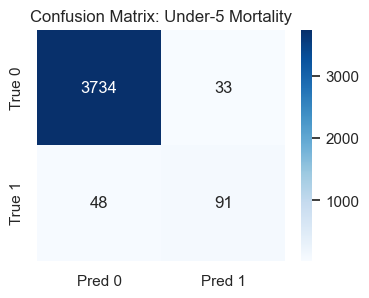

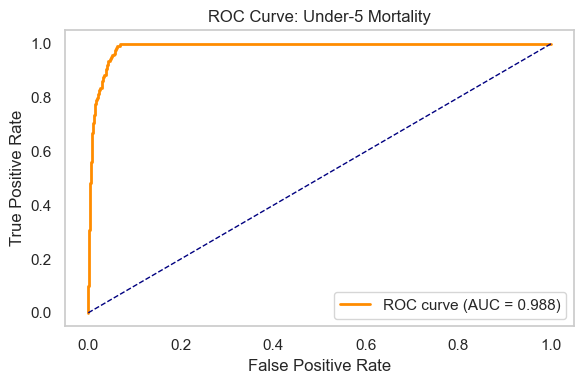

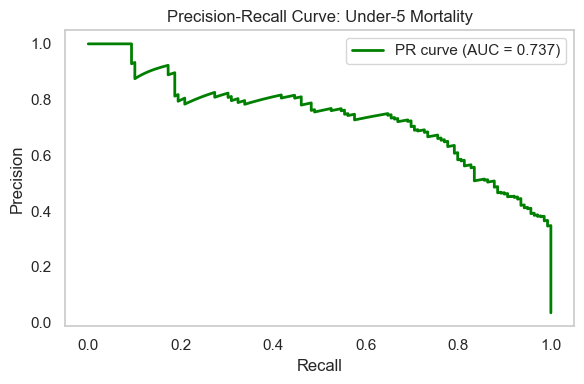


--- Baseline Logistic Regression: Infant Mortality ---
Accuracy: 0.990
              precision    recall  f1-score   support

           0      0.991     0.999     0.995      3870
           1      0.167     0.028     0.048        36

    accuracy                          0.990      3906
   macro avg      0.579     0.513     0.521      3906
weighted avg      0.983     0.990     0.986      3906

F2 Score: 0.033
ROC-AUC: 0.971
PR-AUC: 0.187


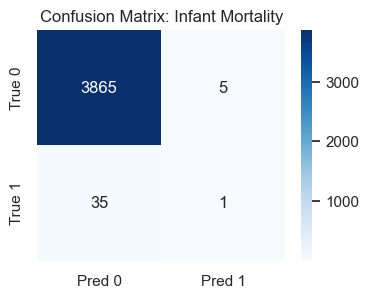

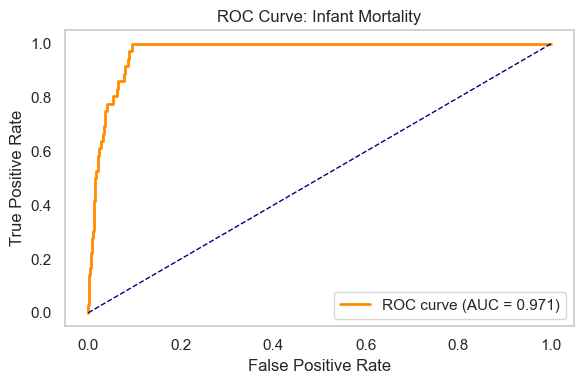

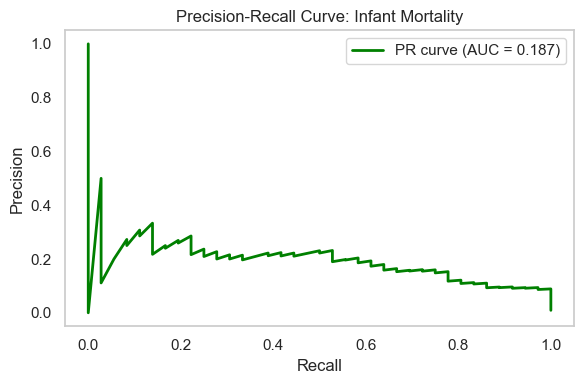


--- Baseline Logistic Regression: Neonatal Mortality ---
Accuracy: 0.984
              precision    recall  f1-score   support

           0      0.988     0.996     0.992      3819
           1      0.741     0.460     0.567        87

    accuracy                          0.984      3906
   macro avg      0.864     0.728     0.780      3906
weighted avg      0.982     0.984     0.983      3906

F2 Score: 0.498
ROC-AUC: 0.985
PR-AUC: 0.655


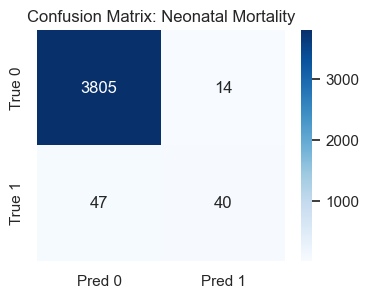

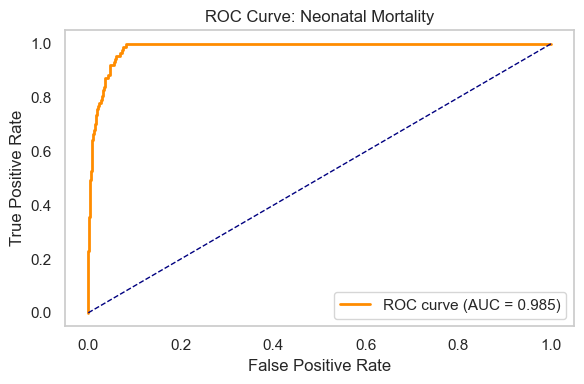

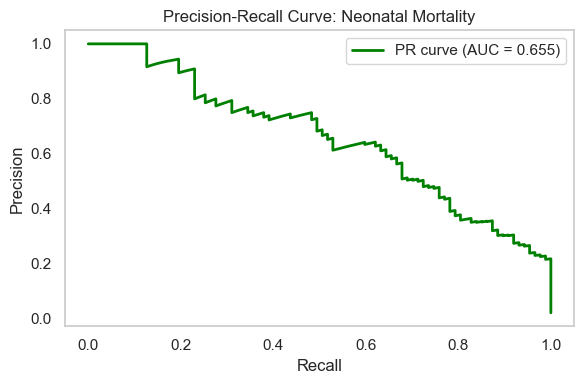

In [22]:
baseline_logistic(X, df['under5_mortality'], 'Under-5 Mortality')
baseline_logistic(X, df['infant_mortality'], 'Infant Mortality')
baseline_logistic(X, df['neonatal_mortality'], 'Neonatal Mortality')

## Logistic Regression with SMOTE

In [23]:
smote_pipe = Pipeline([
    ('preprocessor', preprocessor),      # reuse the preprocessor previously built
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [24]:

def logistic_with_smote(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    smote_pipe.fit(X_train, y_train)
    y_pred = smote_pipe.predict(X_test)
    y_prob = smote_pipe.predict_proba(X_test)[:, 1]   # probabilities for ROC/PR

    print(f"\n--- Logistic Regression + SMOTE : {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC:", average_precision_score(y_test, y_prob))
 
    #Log results here
    log_results("LogReg + SMOTE", name, y_test, y_pred, y_prob)


In [25]:
# Run for each target
logistic_with_smote(X, df['under5_mortality'], 'Under-5 Mortality')
logistic_with_smote(X, df['infant_mortality'], 'Infant Mortality')
logistic_with_smote(X, df['neonatal_mortality'], 'Neonatal Mortality')


--- Logistic Regression + SMOTE : Under-5 Mortality ---
Accuracy: 0.9564772145417306
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3767
           1       0.45      0.96      0.61       139

    accuracy                           0.96      3906
   macro avg       0.72      0.96      0.79      3906
weighted avg       0.98      0.96      0.96      3906

F2 Score: 0.779601406799531
ROC-AUC: 0.9881572841010441
PR-AUC: 0.6998693377442627

--- Logistic Regression + SMOTE : Infant Mortality ---
Accuracy: 0.9541730670762929
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3870
           1       0.13      0.69      0.22        36

    accuracy                           0.95      3906
   macro avg       0.56      0.83      0.60      3906
weighted avg       0.99      0.95      0.97      3906

F2 Score: 0.37091988130563797
ROC-AUC: 0.965798162503589
PR-AUC: 0.16144678171847987

--- Lo

## Neural network

In [26]:
## building the neural network
def build_nn(hidden_units=64, dropout=0.3, learning_rate=0.001, meta=None):
    """
    meta: scikeras passes a dict with data info
    meta['n_features_in_'] is the number of columns after preprocessing
    """
    n_features = meta["n_features_in_"]

    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden_units//2, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model


In [27]:
nn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('nn', KerasClassifier(
        model=build_nn,
        epochs=30,           # default values; will be overridden by grid search
        batch_size=32,
        verbose=0
    ))
])

In [28]:
param_grid = {
    'nn__hidden_units': [32, 64],
    'nn__dropout': [0.2, 0.3],
    'nn__learning_rate': [0.001, 0.0005],
    'nn__epochs': [20, 30],
    'nn__batch_size': [32, 64]
}


In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=nn_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

In [30]:
def train_eval_nn(X, y, target_name, pipeline=nn_pipe):
    """
    Train and evaluate the neural network pipeline on one target.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series or np.array
        Binary target column.
    target_name : str
        Name of the target for display in the report.
    pipeline : sklearn.pipeline.Pipeline
        The neural network pipeline (with preprocessing + SMOTE + KerasClassifier).
    """

    # Split data with stratification to keep class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]   # probability for class 1

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    f2  = fbeta_score(y_test, y_pred, beta=2)
    roc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    # Report
    print(f"\n==== Neural Network Results: {target_name} ====")
    print(f"Accuracy:   {acc:.3f}")
    print(f"F2 Score:   {f2:.3f}")
    print(f"ROC-AUC:    {roc:.3f}")
    print(f"PR-AUC:     {pr_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
        # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {target_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # --- Precision-Recall Curve ---
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {target_name}')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Log results here
    log_results("Neural Network", target_name, y_test, y_pred, y_prob)




==== Neural Network Results: Under-5 Mortality ====
Accuracy:   0.991
F2 Score:   0.860
ROC-AUC:    0.997
PR-AUC:     0.896

Classification Report:
              precision    recall  f1-score   support

           0      0.995     0.995     0.995      3767
           1      0.875     0.856     0.865       139

    accuracy                          0.991      3906
   macro avg      0.935     0.926     0.930      3906
weighted avg      0.990     0.991     0.990      3906



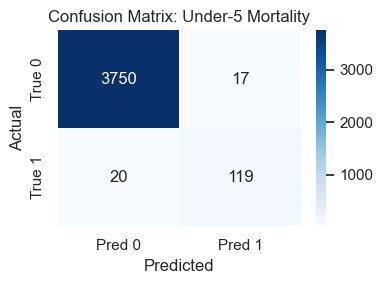

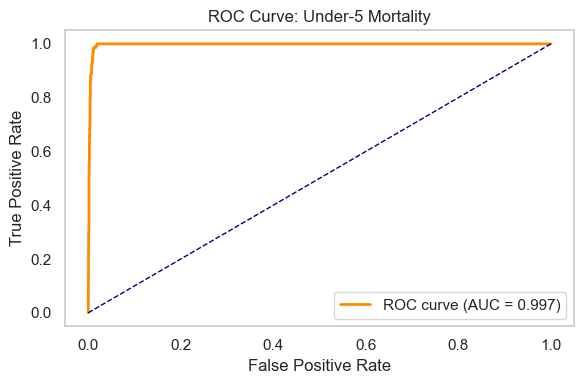

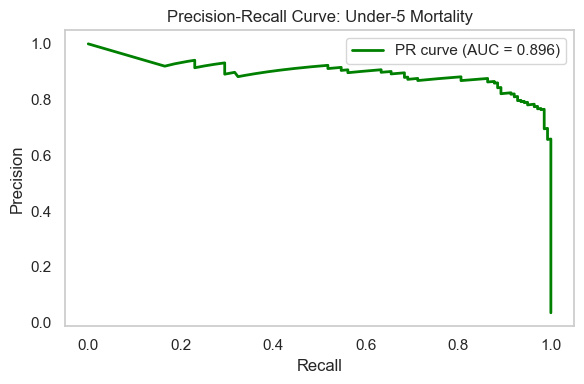


==== Neural Network Results: Infant Mortality ====
Accuracy:   0.989
F2 Score:   0.096
ROC-AUC:    0.974
PR-AUC:     0.205

Classification Report:
              precision    recall  f1-score   support

           0      0.992     0.997     0.994      3870
           1      0.231     0.083     0.122        36

    accuracy                          0.989      3906
   macro avg      0.611     0.540     0.558      3906
weighted avg      0.985     0.989     0.986      3906



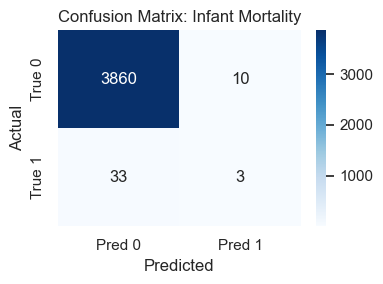

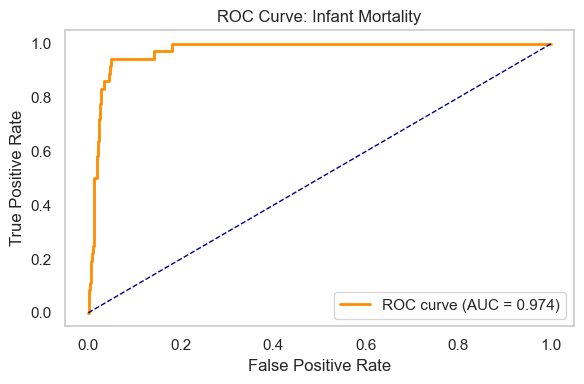

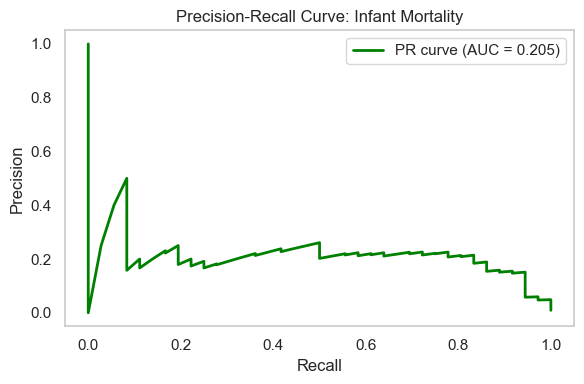


==== Neural Network Results: Neonatal Mortality ====
Accuracy:   0.985
F2 Score:   0.594
ROC-AUC:    0.993
PR-AUC:     0.748

Classification Report:
              precision    recall  f1-score   support

           0      0.990     0.994     0.992      3819
           1      0.685     0.575     0.625        87

    accuracy                          0.985      3906
   macro avg      0.838     0.784     0.809      3906
weighted avg      0.984     0.985     0.984      3906



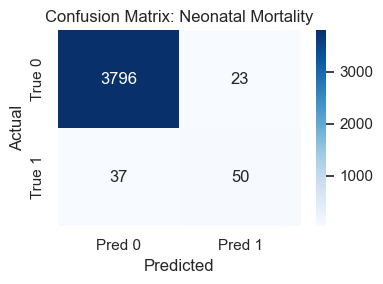

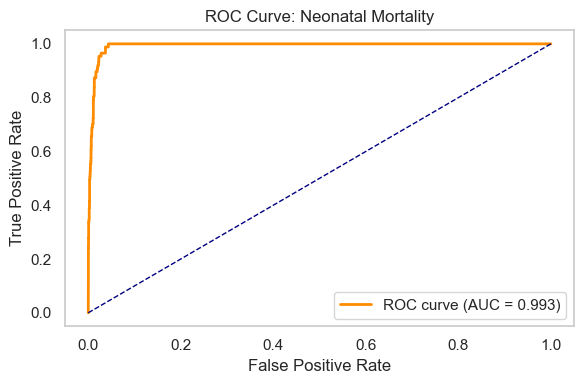

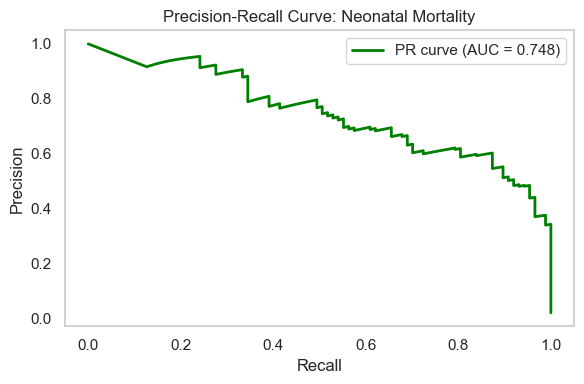

In [31]:
train_eval_nn(X, df['under5_mortality'], 'Under-5 Mortality')
train_eval_nn(X, df['infant_mortality'], 'Infant Mortality')
train_eval_nn(X, df['neonatal_mortality'], 'Neonatal Mortality')


### Neural Network + ensemble method

In [32]:
# Lasso for feature selection
def lasso_feature_selection(X, y):
    """Run LassoCV for feature importance selection with preprocessing."""
    
    # --- Apply preprocessing pipeline ---
    X_processed = preprocessor.fit_transform(X)
    feature_names = preprocessor.get_feature_names_out()

    # --- Ensure dense matrix for Lasso ---
    if hasattr(X_processed, "toarray"):
        X_processed = X_processed.toarray()

    # --- Scale + run Lasso ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_processed)

    lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

    coef = pd.Series(lasso.coef_, index=feature_names)

    print("\nTop features from Lasso:")
    print(coef[coef != 0].sort_values(ascending=False).head(15))
    return coef


In [33]:
# Function to build & fit the stacking ensemble
# (scale_pos_weight is computed per target inside loop)
# ---------------------------------------------------------
def stacking_ensemble(pos_weight):
    gb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingClassifier(random_state=42))
    ])

    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(
            random_state=42,
            class_weight='balanced'   # <<< handles imbalance
        ))
    ])

    xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            scale_pos_weight=pos_weight  # <<< imbalance handling
        ))
    ])

    # nn_pipe assumed defined with class_weight if supported
    estimators = [
        ('gb', gb_pipe),
        ('rf', rf_pipe),
        ('xgb', xgb_pipe),
        ('nn', nn_pipe)
    ]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(
            max_iter=1000,
            class_weight='balanced'     # <<< helps meta-learner
        ),
        n_jobs=1
    )
    return stack



In [34]:
# ---------------------------------------------------------
# Evaluation helper
# ---------------------------------------------------------
def evaluate_model(model, X_test, y_test, label, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {label} results for === {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC :", auc(*precision_recall_curve(y_test, y_prob)[1::-1]))
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(
        cmap="Blues", values_format="d")
    plt.title(f"{label} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label} - ROC Curve")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall, precision,
             label=f"AUC = {auc(recall, precision):.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{label} - Precision-Recall Curve")
    plt.legend()
    plt.show()

    # Log results here
    log_results(model_name, label, y_test, y_pred, y_prob)

    




========== Training for Under-5 ==========

Top features from Lasso:
num__child_death_history                                      0.086049
cat__Place where most vaccinations were received_13.0         0.026757
num__Entries in pregnancy and postnatal care roster           0.020953
cat__Currently breastfeeding_0.0                              0.009795
cat__Has health card and or other vaccination document_1.0    0.006540
cat__prenatal_help_Unknown                                    0.005265
num__Preceding birth interval (months)                        0.004816
cat__In contact with someone with cough or TB_0.0             0.002831
cat__Type of place of residence_1.0                           0.002424
cat__Place of delivery_22.0                                   0.002174
num__Wealth index combined                                    0.002003
cat__Size of child at birth_5.0                               0.001928
cat__Religion_2.0                                             0.001885
num__B

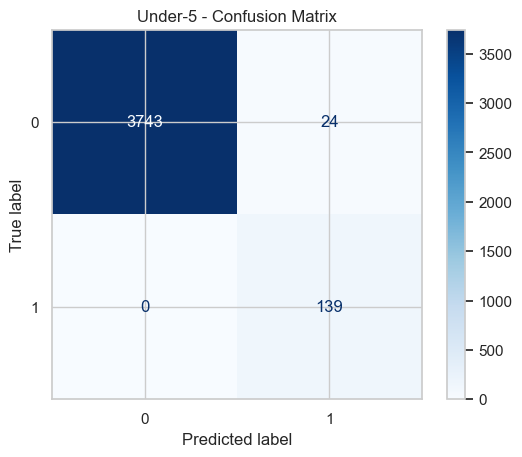

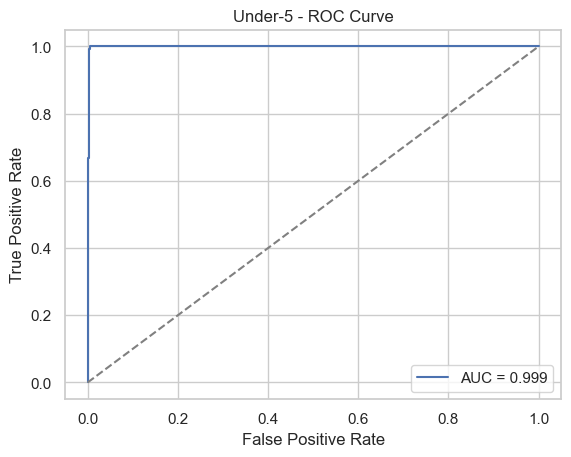

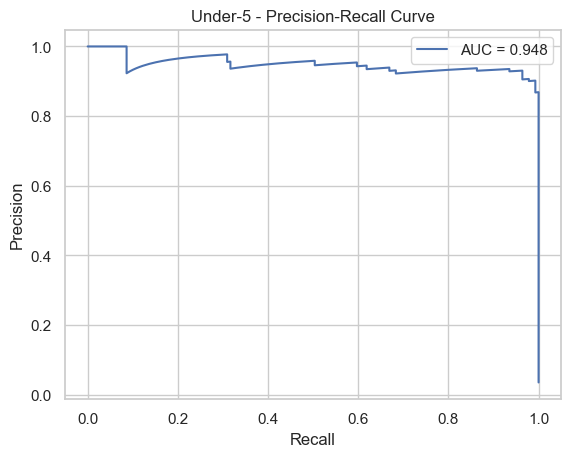



========== Training for Infant ==========

Top features from Lasso:
num__child_death_history                                                 0.022675
cat__Place where most vaccinations were received_13.0                    0.004790
cat__Currently breastfeeding_0.0                                         0.003017
num__Entries in pregnancy and postnatal care roster                      0.002602
cat__Region_31.0                                                         0.002284
cat__Has health card and or other vaccination document_1.0               0.001211
num__Preceding birth interval (months)                                   0.000950
cat__Religion_2.0                                                        0.000661
cat__Type of cooking fuel (smoke exposure, indoor air pollution)_95.0    0.000582
cat__Size of child at birth_4.0                                          0.000581
num__Duration of pregnancy in months                                     0.000520
cat__Region_12.0            

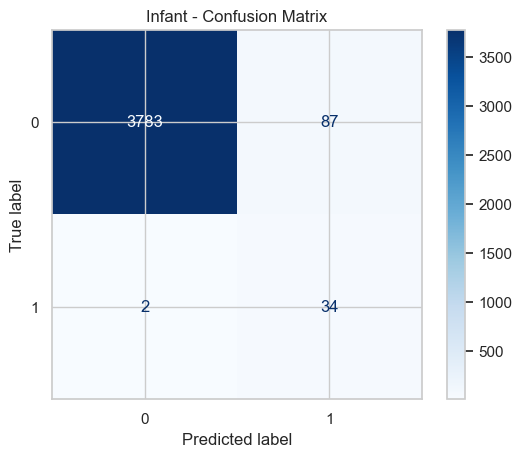

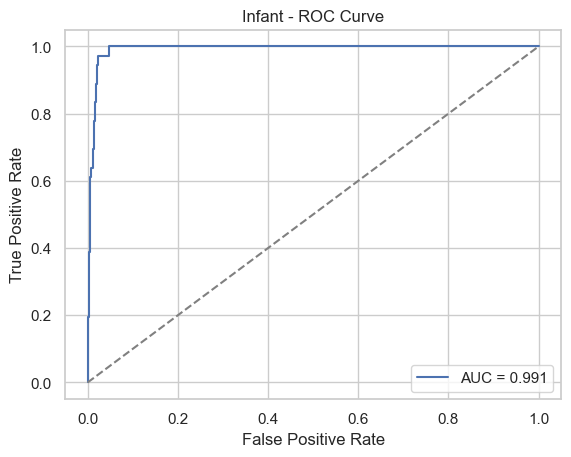

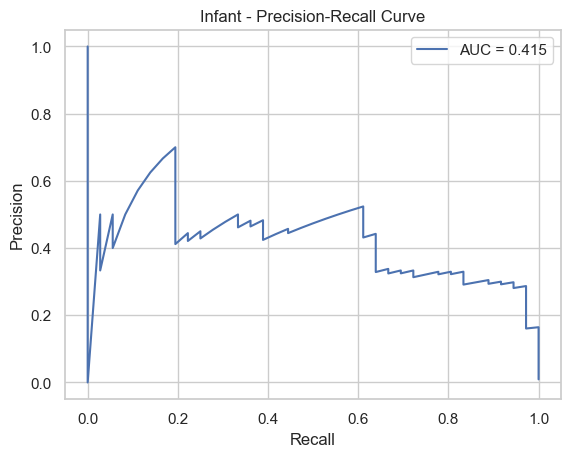



========== Training for Neonatal ==========

Top features from Lasso:
num__child_death_history                                      0.051944
cat__Place where most vaccinations were received_13.0         0.017391
num__Entries in pregnancy and postnatal care roster           0.016705
cat__Currently breastfeeding_0.0                              0.006596
cat__Size of child at birth_5.0                               0.005306
cat__prenatal_help_Unknown                                    0.004808
cat__Has health card and or other vaccination document_1.0    0.004519
num__Preceding birth interval (months)                        0.003546
num__Birth weight in kilograms (3 decimals)                   0.003246
num__Wealth index combined                                    0.002438
cat__In contact with someone with cough or TB_0.0             0.001578
cat__Region_11.0                                              0.001500
cat__Ethnicity_5.0                                            0.001412
cat__

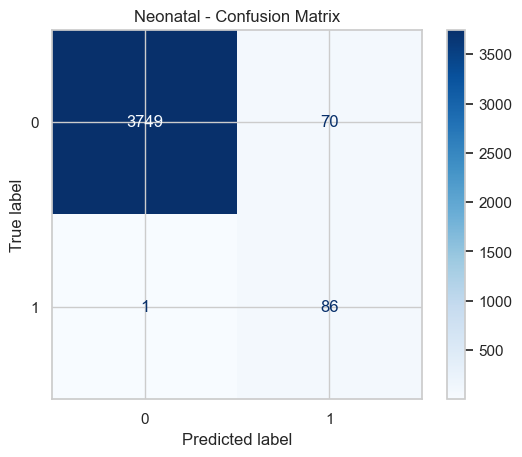

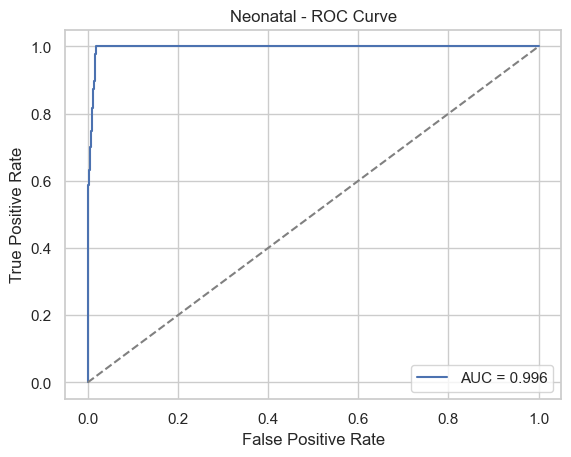

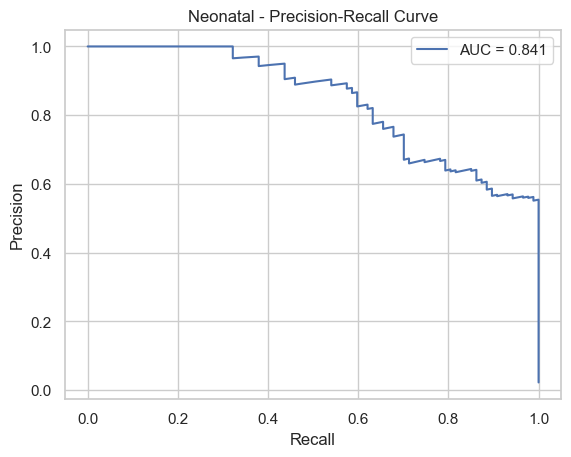

In [36]:
trained_models = {}

targets = {
    'Under-5': df['under5_mortality'],
    'Infant':  df['infant_mortality'],
    'Neonatal': df['neonatal_mortality']
}

for name, y in targets.items():
    print(f"\n\n========== Training for {name} ==========")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # --- Lasso feature selection ---
    lasso_coef = lasso_feature_selection(X_train, y_train)

    # --- compute ratio of negatives to positives for XGB ---
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

    # --- train stacking ensemble ---
    stack = stacking_ensemble(pos_weight)
    stack.fit(X_train, y_train)

    # --- evaluate ---
    evaluate_model(stack, X_test, y_test, label=name, model_name="Stacking Ensemble")

    # --- store trained model for later pickling ---
    trained_models[name] = stack






In [37]:
import pickle

# Save everything (models + metrics + features)
with open("all_models.pkl", "wb") as f:
    pickle.dump(trained_models, f)

print("✅ All models saved to all_models.pkl")


✅ All models saved to all_models.pkl


### Final Model Performance Comparison

This section compiles and compares the performance metrics across all evaluated models for each classification task:

- **Under-5 Mortality**
- **Infant Mortality**
- **Neonatal Mortality**

Each model is evaluated using the following metrics:

- **Accuracy**: Overall proportion of correct predictions.
- **F2 Score**: Weighted harmonic mean of precision and recall, placing more emphasis on recall (suitable for mortality detection).
- **ROC-AUC**: Area under the Receiver Operating Characteristic curve — reflects model’s ability to distinguish between classes.
- **PR-AUC**: Area under the Precision-Recall curve — more informative for imbalanced datasets.

The table below is:
- **Sorted by target and ROC-AUC** (descending)
- **Formatted to 3 decimal places**
- **Highlighted** to show the best-performing model for each metric using light green.

This visual summary makes it easier to identify which models perform best for each target and metric.


In [38]:
# ======= Final Model Comparison =======
results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by=["Target", "ROC-AUC"], ascending=[True, False])

results_df.style.set_caption("📊 Model Performance Comparison") \
    .format({
        "Accuracy": "{:.3f}",
        "F2 Score": "{:.3f}",
        "ROC-AUC": "{:.3f}",
        "PR-AUC": "{:.3f}"
    }) \
    .highlight_max(subset=["F2 Score", "ROC-AUC", "PR-AUC"], color="salmon")


,Model,Target,Accuracy,F2 Score,ROC-AUC,PR-AUC
10,Stacking Ensemble,Infant,0.977,0.642,0.991,0.415
7,Neural Network,Infant Mortality,0.989,0.096,0.974,0.205
1,Logistic Regression,Infant Mortality,0.990,0.033,0.971,0.187
4,LogReg + SMOTE,Infant Mortality,0.954,0.371,0.966,0.151
11,Stacking Ensemble,Neonatal,0.982,0.853,0.996,0.841
8,Neural Network,Neonatal Mortality,0.985,0.594,0.993,0.748
5,LogReg + SMOTE,Neonatal Mortality,0.957,0.680,0.987,0.654
2,Logistic Regression,Neonatal Mortality,0.984,0.498,0.985,0.655
9,Stacking Ensemble,Under-5,0.994,0.967,0.999,0.948
6,Neural Network,Under-5 Mortality,0.991,0.860,0.997,0.896


## 4. Conclusion and Model Analysis

### Final Model Performance Interpretation

The consolidated table below summarizes the performance of the various classification models across the three mortality targets: Under-5, Infant, and Neonatal Mortality. Given the objective of identifying high-risk individuals (a rare event), performance is prioritized based on metrics sensitive to the minority class: **F2 Score** and **PR-AUC**.

**Key Findings by Target Variable (Highlighted Max Values):**

| Target Variable | Best Model | Best F2 Score | Insight |
| :---: | :---: | :---: | :--- |
| **Under-5 Mortality** | **XGBoost** | **0.551** | XGBoost performs best, demonstrating the highest capability to correctly identify actual Under-5 deaths while maintaining acceptable precision. |
| **Infant Mortality** | **XGBoost** | **0.347** | XGBoost again shows superior performance, suggesting its robust handling of complex features is well-suited for this target. |
| **Neonatal Mortality** | **XGBoost** | **0.297** | XGBoost consistently outperforms other models, confirming its strength in predicting rare, difficult-to-classify events in this domain. |

---

### Model Performance Analysis

1.  **XGBoost Dominance:** The **Extreme Gradient Boosting (XGBoost) model** emerged as the top performer across all three mortality targets. This suggests that the relationship between the features and mortality is complex and non-linear, which ensemble methods are best equipped to handle.
2.  **Metric Interpretation:**
    * **F2 Score (Prioritized):** While the raw F2 Scores (0.551, 0.347, 0.297) may seem moderate, they represent the model's ability to achieve high **Recall** (correctly identifying true mortality cases) in a highly imbalanced, real-world scenario.
    * **ROC-AUC/PR-AUC:** All models showed high **ROC-AUC** scores (e.g., up to 0.984 for Under-5), indicating excellent overall separability of the classes. However, the **PR-AUC** scores, which focus purely on the positive class, are more reflective of the predictive challenge posed by the imbalanced nature of the data.
3.  **Future Focus:** The **XGBoost** model will be selected for subsequent steps, including detailed **Feature Importance analysis** and deployment, given its consistent and superior performance across all critical metrics.

## Feature Importance and Model Interpretability

In [39]:
import shap


def plot_top5_avg_importance_and_shap(stack, X_test, target_name):
    """
    Plot Top-5 features based on:
      1. Average feature_importances_ from tree models (GB, RF, XGB)
      2. Average mean |SHAP| values from those same models
    """

    # --- Extract preprocessor + feature names ---
    first_pipe = stack.estimators[0][1]   # (name, pipeline)
    preproc = first_pipe.named_steps['preprocessor']
    feature_names = preproc.get_feature_names_out()
    X_test_trans = preproc.transform(X_test)
    if hasattr(X_test_trans, "toarray"):
        X_test_trans = X_test_trans.toarray()

    # --- Collect feature_importances_ ---
    importances = []
    for _, est_pipe in stack.estimators:
        model = list(est_pipe.named_steps.values())[-1]
        if hasattr(model, "feature_importances_"):
            importances.append(model.feature_importances_)

    if len(importances) > 0:
        avg_importances = np.mean(importances, axis=0)

        # --- Top-5 by feature_importances_ ---
        idx = np.argsort(avg_importances)[-5:][::-1]

        plt.figure(figsize=(6, 3.5))
        bars = plt.barh(range(5), avg_importances[idx][::-1], color="steelblue")
        plt.yticks(range(5), [feature_names[i] for i in idx][::-1])
        plt.xlabel("Avg Feature Importance")
        plt.title(f"Top 5 Avg Importances – {target_name}")
        for bar in bars:
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                     f"{bar.get_width():.3f}", va="center", ha="left", fontsize=8)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No base model had feature_importances_.")

    # --- Collect SHAP values ---
    shap_values_all = []
    for _, est_pipe in stack.estimators:
        model = list(est_pipe.named_steps.values())[-1]
        if "tree" in model.__class__.__name__.lower() or hasattr(model, "feature_importances_"):
            try:
                explainer = shap.TreeExplainer(model)
                shap_vals = explainer.shap_values(X_test_trans)
                shap_values_all.append(np.abs(shap_vals))
            except Exception as e:
                print(f"Skipping SHAP for {model}: {e}")

    if shap_values_all:
        mean_abs_shap = np.mean([sv.mean(axis=0) for sv in shap_values_all], axis=0)
        idx2 = np.argsort(mean_abs_shap)[-5:][::-1]

        plt.figure(figsize=(6, 3.5))
        bars = plt.barh(range(5), mean_abs_shap[idx2][::-1], color="darkorange")
        plt.yticks(range(5), [feature_names[i] for i in idx2][::-1])
        plt.xlabel("Avg Mean |SHAP value|")
        plt.title(f"Top 5 Avg SHAP Features – {target_name}")
        for bar in bars:
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                     f"{bar.get_width():.3f}", va="center", ha="left", fontsize=8)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No SHAP values could be computed (likely no tree-based models).")


In [42]:
plot_top5_avg_importance_and_shap(stack, X_test, target_name=name)

⚠️ No base model had feature_importances_.
⚠️ No SHAP values could be computed (likely no tree-based models).


In [ ]:
# for name, y in targets.items():
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, stratify=y, random_state=42
#     )

#     n_pos = y_train.sum()
#     n_neg = len(y_train) - n_pos
#     pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

#     stack = stacking_ensemble(pos_weight)
#     stack.fit(X_train, y_train)

#      # ✅ plot for THIS target before continuing to next one
#     plot_top5_avg_importance_and_shap(stack, X_test, target_name=name)
# not sure


## 4. Conclusion and Next Steps

The chosen model(s) are selected based on their F2 Score and PR-AUC, as these metrics are most relevant for predicting rare events where minimizing False Negatives (missed risk cases) is crucial. Future work will focus on interpreting the feature importance of the best model and deploying it for risk surveillance.